In [490]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math

import geopandas as gpd
import contextily as cx

from matplotlib.colors import TwoSlopeNorm
from sklearn.preprocessing import MinMaxScaler

## 2. Match maps to election return data for each district.

In [198]:
# Taking processed efficiency gap dataset
df = pd.read_csv("intermediate\efficiency_gap_by_congressional_district_post_1948.csv", index_col=0)

df.head()

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,Party,total_votes,net_wasted_votes,total_districts,state_total_dem_votes,state_total_gop_votes,state_total_votes,state_net_wasted_votes,efficiency_gap,dem_state_voteshare,dem_state_seatshare
0,AL,1948,1,19778,0,1.000000,D,19778,9888,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.0
1,AL,1948,2,21271,0,1.000000,D,21271,10635,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.0
2,AL,1948,3,16279,0,1.000000,D,16279,8139,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.0
3,AL,1948,4,17282,3054,0.849823,D,20336,4059,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.0
4,AL,1948,5,20548,0,1.000000,D,20548,10273,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.0


Creating basic maps using historical congressional state boundaries

Using Congress 113th maps (2011-2012) as an example

In [223]:
geo_df = gpd.read_file("data/maps/113_districtShapes")

geo_df.head()

,STATENAME,ID,DISTRICT,STARTCONG,ENDCONG,DISTRICTSI,COUNTY,PAGE,LAW,NOTE,BESTDEC,FINALNOTE,RNOTE,LASTCHANGE,FROMCOUNTY,geometry
0,Louisiana,022113114006,6,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"MULTIPOLYGON (((-91.82288 30.85806, -91.82264 ..."
1,Maine,023113114001,1,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"MULTIPOLYGON (((-70.98905 43.79215, -70.98849 ..."
2,Maine,023113114002,2,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"MULTIPOLYGON (((-71.08216 45.30631, -71.08169 ..."
3,Maryland,024113114001,1,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"MULTIPOLYGON (((-77.31156 39.63875, -77.31154 ..."
4,Maryland,024113114002,2,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"MULTIPOLYGON (((-76.87630 39.14132, -76.87622 ..."


In [224]:
geo_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

 We need to join both tables - based on State FIPS + year (congress session no.) 
 
 (FIPS using reference from [US BLS](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm), Congress session no. using reference from [UCLA PoliSci Dept](https://cdmaps.polisci.ucla.edu/))

In [225]:
# Converting Congress sessions to years
session_dict = dict(zip(list(range(81, 116)), list(range(1948, 2017, 2))))

# Converting state FIPS code into two-letter abbreviations
state_fips_dict = pd.read_csv("data/state_fips.csv")[["FIPS Code", "Postal Abbr."]].set_index("FIPS Code").to_dict()['Postal Abbr.']

In [226]:
## 12-digit ID structure: [3-digit state FIPS][3-digit first congress][3-digit last congress][3-digit district no.]
geo_df["STATE_FIPS"] = geo_df["ID"].apply(lambda x: int(x[0:3]))
geo_df["STATE_AB"] = geo_df["STATE_FIPS"].map(state_fips_dict)
geo_df[["STATENAME", "ID", "STATE_FIPS", "STATE_AB"]].head()

,STATENAME,ID,STATE_FIPS,STATE_AB
0,Louisiana,022113114006,22,LA
1,Maine,023113114001,23,ME
2,Maine,023113114002,23,ME
3,Maryland,024113114001,24,MD
4,Maryland,024113114002,24,MD


In [227]:
# Convert type for joining
geo_df["DISTRICT"] = geo_df["DISTRICT"].astype("int")

# Convert at-large (single-district) states (labelled district 0) into district 1
geo_df.loc[geo_df["DISTRICT"] == 0, "DISTRICT"] = 1

In [228]:
year = session_dict[113]

# Right join to preserve GeoDataFrame object while joining all district data
df_2012 = geo_df.merge(df[df["Year"]==year], how="right", left_on=["STATE_AB", "DISTRICT"], right_on=["State", "District"])

df_2012.shape

(428, 35)

In [229]:
# All columns are matched
df_2012[["STATE_AB", "ID", "DISTRICT", "State", "Year"]].isna().sum()

STATE_AB    0
ID          0
DISTRICT    0
State       0
Year        0
dtype: int64

#### Plotting basic maps

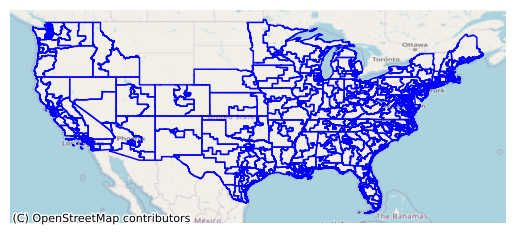

In [230]:
# Let's remove Hawaii for easier visualization - we will keep it in during final training

ax = df_2012[~(df_2012["STATE_AB"]=="HI")].plot(facecolor="none", edgecolor="blue")
ax.set_axis_off()
cx.add_basemap(ax, crs=df_2012.crs, source=cx.providers.OpenStreetMap.Mapnik)  

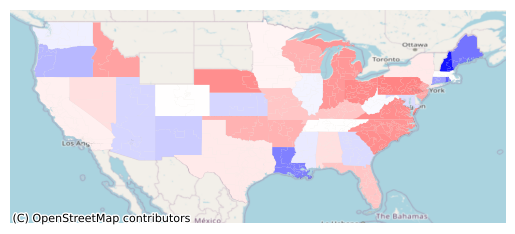

In [231]:
# Efficiency Gap visualization in 2012 - empty states are single-district states

# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)

ax = df_2012[~(df_2012["STATE_AB"]=="HI")].plot(column="efficiency_gap", cmap="bwr", norm=norm, missing_kwds={"color": "lightgrey"})
ax.set_axis_off()
cx.add_basemap(ax, crs=df_2012.crs, source=cx.providers.OpenStreetMap.Mapnik)  

In [232]:
# Top 3 for both sides in efficiency gap

df_2012[df_2012["DISTRICT"] == 1][["STATENAME", "efficiency_gap"]].sort_values(by="efficiency_gap").iloc[np.r_[0:3, -3:0]]

,STATENAME,efficiency_gap
237,New Hampshire,-0.46
338,Rhode Island,-0.32
177,Maine,-0.27
230,Nebraska,0.22
294,Ohio,0.23
320,Pennsylvania,0.24


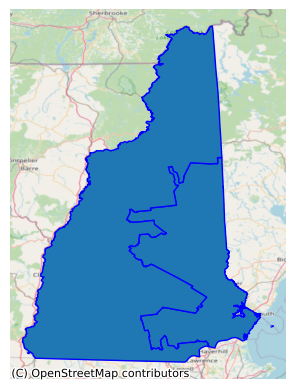

In [233]:
# New Hampshire in 2012

ax = df_2012[df_2012["STATE_AB"]=="NH"].plot(edgecolor="blue")
ax.set_axis_off()
cx.add_basemap(ax, crs=df_2012.crs, source=cx.providers.OpenStreetMap.Mapnik)  

In [234]:
df[(df["State"] == "NH") & (df["Year"] == 2012)][["State", "Year", "District", "Dem Votes", "GOP Votes", "D Voteshare", "efficiency_gap", "dem_state_voteshare", "dem_state_seatshare"]]

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,efficiency_gap,dem_state_voteshare,dem_state_seatshare
10320,NH,2012,1,171650,158659,0.519665,-0.46,0.52,1.0
10321,NH,2012,2,169275,152977,0.525288,-0.46,0.52,1.0


The graph does make sense - for example, both of New Hampshire's districts are heavily contested in 2012 (NH-1 is D+2.0, NH-2 is D+2.5, both in swing-county territory). Democrats hold 52% of total votes but control 100% of house seats, effectively leaving the republican-leaning 48% of NH's population with no representation in the House, and a -0.46 efficiency gap. 

We want to introduce extra information by colouring in maps - we can introduce different types of layers here.

#### Past Voting Results

For example, will now tack on a heatmap of voting results in the previous election cycle (last known voting info). It will make redistricting much clearer, and should theoretically help the CNN better recognise gerrymandering.

In our example, we should be able to visually tell the impact of the 2011 redistricting efforts.

In [235]:
prev_geo_df = gpd.read_file("data/maps/112_districtShapes")

# Convert State FIPS to two-letter abbreviations
prev_geo_df["STATE_FIPS"] = prev_geo_df["ID"].apply(lambda x: int(x[0:3]))
prev_geo_df["STATE_AB"] = prev_geo_df["STATE_FIPS"].map(state_fips_dict)
prev_geo_df[["STATENAME", "ID", "STATE_FIPS", "STATE_AB"]].head()

# Convert type for joining
prev_geo_df["DISTRICT"] = prev_geo_df["DISTRICT"].astype("int")

# Convert at-large (single-district) states (labelled district 0) into district 1
prev_geo_df.loc[prev_geo_df["DISTRICT"] == 0, "DISTRICT"] = 1

df_2010 = prev_geo_df.merge(df[df["Year"]==(year-2)], how="right", left_on=["STATE_AB", "DISTRICT"], right_on=["State", "District"])

df_2010.head()

,STATENAME,ID,DISTRICT,STARTCONG,ENDCONG,DISTRICTSI,COUNTY,PAGE,LAW,NOTE,...,total_votes,net_wasted_votes,total_districts,state_total_dem_votes,state_total_gop_votes,state_total_votes,state_net_wasted_votes,efficiency_gap,dem_state_voteshare,dem_state_seatshare
0,Alabama,001108112001,1,108,112,None,None,None,None,None,...,129063,-64531,7.0,418957.0,914445.0,1333402.0,-17369.0,-0.01,0.31,0.14
1,Alabama,001108112002,2,108,112,None,None,None,None,None,...,218510,104476,7.0,418957.0,914445.0,1333402.0,-17369.0,-0.01,0.31,0.14
2,Alabama,001108112003,3,108,112,None,None,None,None,None,...,197940,61439,7.0,418957.0,914445.0,1333402.0,-17369.0,-0.01,0.31,0.14
3,Alabama,001108112004,4,108,112,None,None,None,None,None,...,167714,-83856,7.0,418957.0,914445.0,1333402.0,-17369.0,-0.01,0.31,0.14
4,Alabama,001108112005,5,108,112,None,None,None,None,None,...,226301,77234,7.0,418957.0,914445.0,1333402.0,-17369.0,-0.01,0.31,0.14


We can engineer partisan lean with each district's voteshare on a range from -50% (100% republican) to 50% (100% democratic) - 0% will be perfectly equal (D+0.0). This will change per district.



In [236]:
df_2010["partisan_lean"] = df_2010["D Voteshare"] - 0.5

df_2010["partisan_lean"].describe()

count    428.000000
mean      -0.026710
std        0.208010
min       -0.500000
25%       -0.171160
50%       -0.028026
75%        0.110119
max        0.500000
Name: partisan_lean, dtype: float64

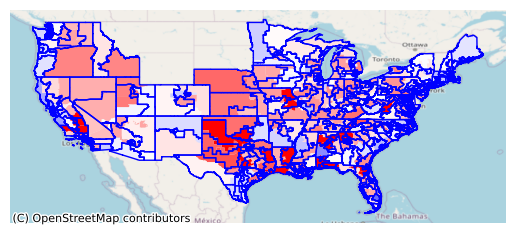

In [237]:
# New districts (2012) on top of 2010 district voting results  - empty states are single-district states

f, ax = plt.subplots()

# Plot 2010 district voting results 
# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
df_2010[~(df_2010["STATE_AB"]=="HI")].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, missing_kwds={"color": "lightgrey"}, ax=ax)

# Plot 2012 boundaries
df_2012[~(df_2012["STATE_AB"]=="HI")].plot(ax=ax, facecolor="none", edgecolor="blue")

ax.set_axis_off()
cx.add_basemap(ax, crs=df_2012.crs, source=cx.providers.OpenStreetMap.Mapnik)  

Let's take a look at one state - California - to make this effect more obvious

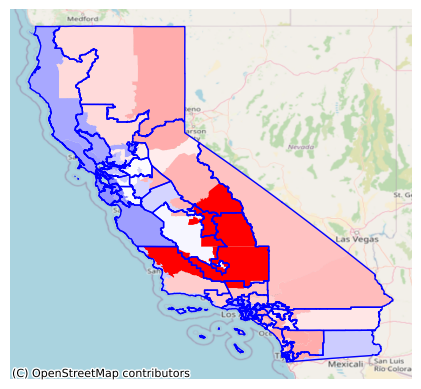

In [238]:
# New California districts (2012) on top of 2010 district voting results

f, ax = plt.subplots()

# Plot 2010 district voting results 
# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
df_2010[df_2010["STATE_AB"]=="CA"].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, missing_kwds={"color": "lightgrey"}, ax=ax)

# Plot 2012 boundaries
df_2012[df_2012["STATE_AB"]=="CA"].plot(ax=ax, facecolor="none", edgecolor="blue")

ax.set_axis_off()
cx.add_basemap(ax, crs=df_2012.crs, source=cx.providers.OpenStreetMap.Mapnik)  

This graph shows the impact of the 2011 redistricting on California - the new boundaries in 2012 are very far apart from 2010 voting results.

We can remove the background for more clarity - helps the CNN train on features that are important (+ less filters for faster training)

Let's try to plot the most "gerrymandered" states after the 2011 redistricting - the biggest increases in efficiency gaps between the 2010 and 2012 election cycles. Both plots will be using the updated boundaries to show how the gerrymandering occured.

In [292]:
gm_change = df_2010[df_2010["DISTRICT"] == 1][["STATENAME", "efficiency_gap"]].merge(df_2012[df_2012["DISTRICT"] == 1][["STATENAME", "efficiency_gap"]], how="inner", on="STATENAME")
gm_change = gm_change.rename(columns={"efficiency_gap_x": "efficiency_gap_2010", "efficiency_gap_y": "efficiency_gap_2012"})
gm_change["efficiency_gap_change"] = abs(gm_change["efficiency_gap_2012"] - gm_change["efficiency_gap_2010"])

gm_change.sort_values(by="efficiency_gap_change", ascending=False).head(4)
# gm_change[["STATENAME", "efficiency_gap_change"]].sort_values(by="efficiency_gap_change", ascending=False).head(4)

,STATENAME,efficiency_gap_2010,efficiency_gap_2012,efficiency_gap_change
25,New Hampshire,0.43,-0.46,0.89
29,North Carolina,-0.13,0.21,0.34
31,Oklahoma,-0.16,0.15,0.31
13,Kansas,0.18,-0.08,0.26


In [266]:
# Partisan Lean in 2012
df_2012["partisan_lean"] = df_2012["D Voteshare"] - 0.5

In [332]:
# total seats in top states
total_seats_NH_2010 = df[(df["State"]=="NH") & (df["Year"] == 2010) & (df["District"]==1)]["total_districts"].values[0]
total_seats_NH_2012 = df[(df["State"]=="NH") & (df["Year"] == 2012) & (df["District"]==1)]["total_districts"].values[0]
total_seats_NC_2010 = df[(df["State"]=="NC") & (df["Year"] == 2010) & (df["District"]==1)]["total_districts"].values[0]
total_seats_NC_2012 = df[(df["State"]=="NC") & (df["Year"] == 2012) & (df["District"]==1)]["total_districts"].values[0]
total_seats_OK_2010 = df[(df["State"]=="OK") & (df["Year"] == 2010) & (df["District"]==1)]["total_districts"].values[0]
total_seats_OK_2012 = df[(df["State"]=="OK") & (df["Year"] == 2012) & (df["District"]==1)]["total_districts"].values[0]
total_seats_KS_2010 = df[(df["State"]=="KS") & (df["Year"] == 2010) & (df["District"]==1)]["total_districts"].values[0]
total_seats_KS_2012 = df[(df["State"]=="KS") & (df["Year"] == 2012) & (df["District"]==1)]["total_districts"].values[0]

# Seat Share per year/party
dem_seats_NH_2010 = math.floor((df_2010[(df_2010["STATE_AB"]=="NH") & (df_2010["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_NH_2010).values[0])
rep_seats_NH_2010 = int(total_seats_NH_2010 - dem_seats_NH_2010)
dem_seats_NH_2012 = math.floor((df_2012[(df_2012["STATE_AB"]=="NH") & (df_2012["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_NH_2012).values[0])
rep_seats_NH_2012 = int(total_seats_NH_2012 - dem_seats_NH_2012)

dem_seats_NC_2010 = math.floor((df_2010[(df_2010["STATE_AB"]=="NC") & (df_2010["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_NC_2010).values[0])
rep_seats_NC_2010 = int(total_seats_NC_2010 - dem_seats_NC_2010)
dem_seats_NC_2012 = math.floor((df_2012[(df_2012["STATE_AB"]=="NC") & (df_2012["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_NC_2012).values[0])
rep_seats_NC_2012 = int(total_seats_NC_2012 - dem_seats_NC_2012)

dem_seats_OK_2010 = math.floor((df_2010[(df_2010["STATE_AB"]=="OK") & (df_2010["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_OK_2010).values[0])
rep_seats_OK_2010 = int(total_seats_OK_2010 - dem_seats_OK_2010)
dem_seats_OK_2012 = math.floor((df_2012[(df_2012["STATE_AB"]=="OK") & (df_2012["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_OK_2012).values[0])
rep_seats_OK_2012 = int(total_seats_OK_2012 - dem_seats_OK_2012)

dem_seats_KS_2010 = math.floor((df_2010[(df_2010["STATE_AB"]=="KS") & (df_2010["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_KS_2010).values[0])
rep_seats_KS_2010 = int(total_seats_KS_2010 - dem_seats_KS_2010)
dem_seats_KS_2012 = math.floor((df_2012[(df_2012["STATE_AB"]=="KS") & (df_2012["DISTRICT"]==1)]["dem_state_seatshare"] * total_seats_KS_2012).values[0])
rep_seats_KS_2012 = int(total_seats_KS_2012 - dem_seats_KS_2012)

Text(0.5, 1.0, 'Kansas\n2012 Voting Results (2012 Boundaries)\nDem Seats: 0, Rep Seats: 4')

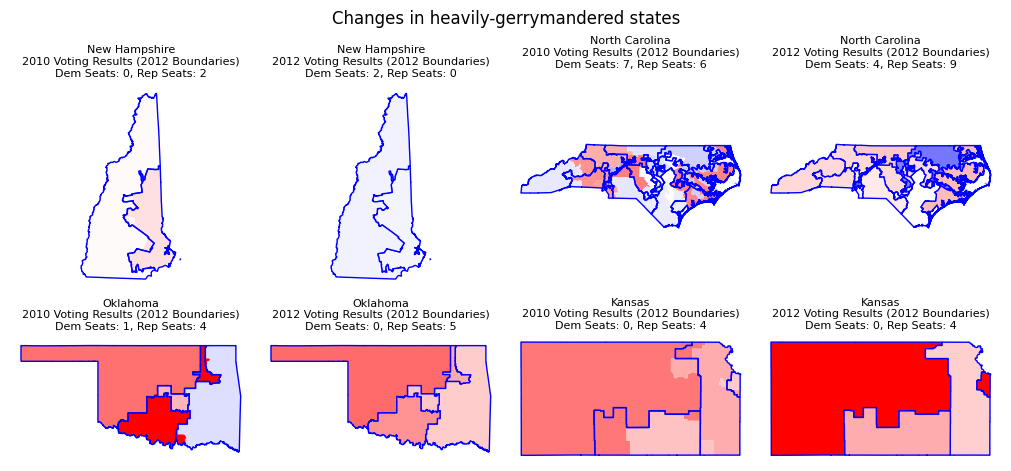

In [373]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5), constrained_layout=True)

fig.suptitle("Changes in heavily-gerrymandered states")

# Plot 1: NH 2010
# Plot 2010 district voting results 
# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
df_2010[df_2010["STATE_AB"]=="NH"].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[0, 0])

# Plot 2012 boundaries
df_2012[df_2012["STATE_AB"]=="NH"].plot(ax=ax[0, 0], facecolor="none", edgecolor="blue")
ax[0, 0].set_axis_off()
ax[0, 0].set_title(f"New Hampshire\n2010 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_NH_2010}, Rep Seats: {rep_seats_NH_2010}", fontsize=8) 

# Plot 2: NH 2012

df_2012[df_2012["STATE_AB"]=="NH"].plot(edgecolor="blue", column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[0, 1])
ax[0, 1].set_axis_off()
ax[0, 1].set_title(f"New Hampshire\n2012 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_NH_2012}, Rep Seats: {rep_seats_NH_2012}", fontsize=8)

# Plot 3: NC 2010
# Plot 2010 district voting results 
df_2010[df_2010["STATE_AB"]=="NC"].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[0, 2])

# Plot 2012 boundaries
df_2012[df_2012["STATE_AB"]=="NC"].plot(ax=ax[0, 2], facecolor="none", edgecolor="blue")
ax[0, 2].set_axis_off()
ax[0, 2].set_title(f"North Carolina\n2010 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_NC_2010}, Rep Seats: {rep_seats_NC_2010}", fontsize=8, pad=53) 

# Plot 4: NC 2012

df_2012[df_2012["STATE_AB"]=="NC"].plot(edgecolor="blue", column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[0, 3])
ax[0, 3].set_axis_off()
ax[0, 3].set_title(f"North Carolina\n2012 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_NC_2012}, Rep Seats: {rep_seats_NC_2012}", fontsize=8, pad=53)

# Plot 5: OK 2010
# Plot 2010 district voting results 
df_2010[df_2010["STATE_AB"]=="OK"].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[1, 0])

# Plot 2012 boundaries
df_2012[df_2012["STATE_AB"]=="OK"].plot(ax=ax[1, 0], facecolor="none", edgecolor="blue")
ax[1, 0].set_axis_off()
ax[1, 0].set_title(f"Oklahoma\n2010 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_OK_2010}, Rep Seats: {rep_seats_OK_2010}", fontsize=8, pad=8) 

# Plot 6: OK 2012

df_2012[df_2012["STATE_AB"]=="OK"].plot(edgecolor="blue", column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[1, 1])
ax[1, 1].set_axis_off()
ax[1, 1].set_title(f"Oklahoma\n2012 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_OK_2012}, Rep Seats: {rep_seats_OK_2012}", fontsize=8, pad=8)

# Plot 7: KS 2010
# Plot 2010 district voting results 
df_2010[df_2010["STATE_AB"]=="KS"].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[1, 2])

# Plot 2012 boundaries
df_2012[df_2012["STATE_AB"]=="KS"].plot(ax=ax[1, 2], facecolor="none", edgecolor="blue")
ax[1, 2].set_axis_off()
ax[1, 2].set_title(f"Kansas\n2010 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_KS_2010}, Rep Seats: {rep_seats_KS_2010}", fontsize=8) 

# Plot 8: NC 2012

df_2012[df_2012["STATE_AB"]=="KS"].plot(edgecolor="blue", column="partisan_lean", cmap="bwr_r", norm=norm, ax=ax[1, 3])
ax[1, 3].set_axis_off()
ax[1, 3].set_title(f"Kansas\n2012 Voting Results (2012 Boundaries)\nDem Seats: {dem_seats_KS_2012}, Rep Seats: {rep_seats_KS_2012}", fontsize=8)

Here are 4 states with the biggest efficiency gap swings. The boundaries are after redistricting - in all cases they've had a significant effect on the state by emphasizing the margin of winning districts or even flipping close districts.

This effect is most clear in North Carolina, where boundaries are completely different and often in oblique shapes - often signs of packing and cracking. The left side of the state has now been spread out to split Republican advantages across multiple light-red districts (cracking), while the democratic top right has now been heavily packed to allow Republicans to take multiple counties surrounding the area (packing). They flipped 3 seats and [took control](https://www.270towin.com/states/North_Carolina) of their state.

#### City visualizations

Often times, cracking and packing is done in urban areas (by breaking up/packing highly dense, usually democratic-leaning populations) as urban populations contain a large population (that can swing election outcomes heavily) in a small area. We can put these urban areas on a map and track their differences over time.

In [480]:
# Cities + population sizes over time (every 10 yrs)
city_df = pd.read_csv("data/1790-2010_CITY_POP_MASTER.csv", index_col = "ID").iloc[:, :-4]

# Plotted cities have >100K residents
city_df = city_df[city_df["2010"] >= 100000].sort_values(by="2010", ascending=False)

# Converting into GeoDataFrame to allow for plotting
city_df = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.LON, city_df.LAT), crs="EPSG:4326")

print(city_df.shape)
city_df.head()

(274, 34)


,ST,City,CityST,1790,1800,1810,1820,1830,1840,1850,...,2000,2010,STPLFIPS_2010,Name_2010,County,LAT,LON,LAT_BING,LON_BING,geometry
ID,,,,,,,,,,,,,,,,,,,,,
4768,NY,New York City,"New York City, NY",33131.0,60515.0,96373.0,123706.0,202589.0,312710.0,515547.0,...,8008278.0,8175133.0,3651000.0,New York city,NEW YORK,40.664274,-73.938500,40.7820014953613,-73.832703,POINT (-73.93850 40.66427)
596,CA,Los Angeles,"Los Angeles, CA",0.0,0.0,0.0,0.0,0.0,0.0,1610.0,...,3694820.0,3792621.0,644000.0,Los Angeles city,LOS ANGELES,34.019394,-118.410825,34.0534896850585,-118.245323,POINT (-118.41082 34.01939)
1864,IL,Chicago,"Chicago, IL",0.0,0.0,0.0,0.0,0.0,4470.0,29963.0,...,2896016.0,2695598.0,1714000.0,Chicago city,COOK,41.837551,-87.681844,41.8842506408691,-87.632446,POINT (-87.68184 41.83755)
6536,TX,Houston,"Houston, TX",0.0,0.0,0.0,0.0,0.0,0.0,2400.0,...,1953631.0,2099451.0,4835000.0,Houston city,HARRIS,29.780472,-95.386342,29.7604503631591,-95.369781,POINT (-95.38634 29.78047)
5848,PA,Philadelphia,"Philadelphia, PA",28522.0,41220.0,53722.0,63802.0,80462.0,93665.0,121376.0,...,1517550.0,1526006.0,4260000.0,Philadelphia city,PHILADELPHIA,40.009375,-75.133346,39.952278137207,-75.162453,POINT (-75.13335 40.00938)


In [481]:
# Map as coordinate reference system (CRS)
geo_df_2024 = gpd.read_file("data/maps/2024_district_shapes")

In [482]:
geo_df_2024["STATEFP20"] = geo_df_2024["STATEFP20"].astype("int")

# Remove non-voting territories + Hawaii/Alaska (easier to plot)
geo_df_2024 = geo_df_2024[~(geo_df_2024["STATEFP20"] > 56) & ~(geo_df_2024["STATEFP20"].isin([2, 15]))]

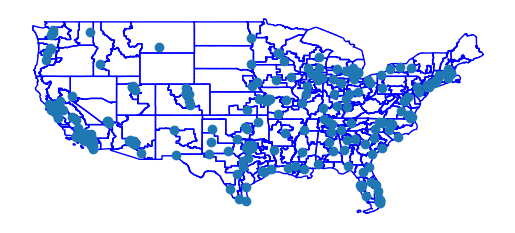

In [521]:
ax = geo_df_2024.plot(facecolor="none", edgecolor="blue")
city_df[~(city_df["ST"].isin(["AK", "HI"]))].plot(ax=ax, aspect=1)
ax.set_axis_off()
plt.show()

Let's try plotting cities with point sizes depending on size of city. We can use the previous 2012 California plot with cities labelled. 

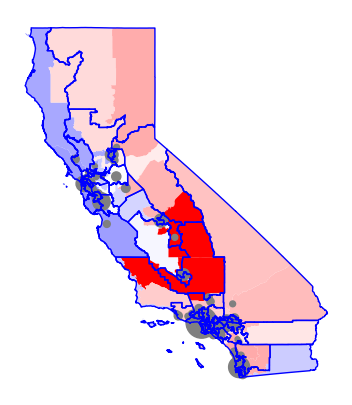

In [520]:
# New California districts (2012) on top of 2010 district voting results, cities labelled depending on size

f, ax = plt.subplots(figsize=(5, 5))

# Layer 1: Plot 2010 district voting results 
# normalize color
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
df_2010[df_2010["STATE_AB"]=="CA"].to_crs(df_2010.crs).plot(column="partisan_lean", cmap="bwr_r", norm=norm, missing_kwds={"color": "lightgrey"}, ax=ax)

# Layer 2: Plot points for cities depending on 2010 census population
# Artificial scaler as markersize: (val-min)/(max-min)
city_df[city_df["ST"]=="CA"].plot(ax=ax, aspect=1, color="gray", markersize=((city_df["2010"]-city_df["2010"].min()) / (city_df["2010"].max()-city_df["2010"].min()))*500)

# Layer 3: Plot 2012 congressional district boundaries
df_2012[df_2012["STATE_AB"]=="CA"].plot(ax=ax, facecolor="none", edgecolor="blue")

ax.set_axis_off()
plt.show()

## 3. Turn maps into standardized pictures.

This step involves automating the creation of the 3 layers above for each map. 

Photos should be standardized in sizes (figsize in [centimeters](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html)).

We are only using training images where redistricting has happened (applicable to our use case after 2021 redistricting).

In [ ]:
# list(session_dict.keys()).apply(lambda x:)

In [ ]:
#for session in 